# تحليل الأوراق البحثية حول كوفيد-19

في هذا التحدي، سنواصل الحديث عن جائحة كوفيد، مع التركيز على معالجة الأوراق العلمية المتعلقة بالموضوع. هناك [مجموعة بيانات CORD-19](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) تحتوي على أكثر من 7000 ورقة بحثية (في وقت كتابة هذا النص) حول كوفيد، متوفرة مع بيانات وصفية وملخصات (ولحوالي نصفها يتوفر النص الكامل أيضًا).

مثال كامل لتحليل هذه المجموعة باستخدام [تحليلات النصوص للصحة](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) من خدمات الذكاء الاصطناعي موضح [في هذه المقالة](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). سنناقش نسخة مبسطة من هذا التحليل.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## الحصول على البيانات

أولاً، نحتاج إلى الحصول على البيانات الوصفية لأوراق CORD التي سنعمل عليها.

**ملاحظة**: نحن لا نوفر نسخة من مجموعة البيانات كجزء من هذا المستودع. قد تحتاج أولاً إلى تنزيل ملف [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) من [مجموعة البيانات هذه على Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). قد يكون التسجيل في Kaggle مطلوبًا. يمكنك أيضًا تنزيل مجموعة البيانات بدون تسجيل [من هنا](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html)، ولكنها ستتضمن جميع النصوص الكاملة بالإضافة إلى ملف البيانات الوصفية.

سنحاول الحصول على البيانات مباشرة من المصدر عبر الإنترنت، ولكن إذا فشل ذلك، ستحتاج إلى تنزيل البيانات كما هو موضح أعلاه. أيضًا، من المنطقي تنزيل البيانات إذا كنت تخطط لإجراء المزيد من التجارب عليها، لتوفير وقت الانتظار.

> **ملاحظة** أن مجموعة البيانات كبيرة جدًا، حوالي 1 جيجابايت، وقد يستغرق تنفيذ السطر التالي من الكود وقتًا طويلاً! (~5 دقائق)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

سنقوم الآن بتحويل عمود تاريخ النشر إلى `datetime`، ورسم المدرج التكراري لرؤية نطاق تواريخ النشر.


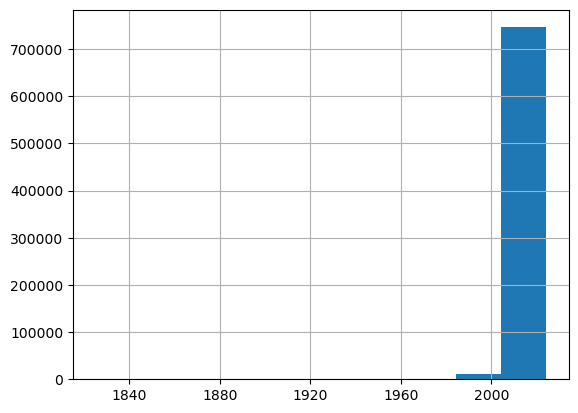

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## استخراج البيانات المنظمة

لنرى نوع المعلومات التي يمكننا استخراجها بسهولة من الملخصات. أحد الأمور التي قد تهمنا هو معرفة استراتيجيات العلاج الموجودة وكيف تطورت مع مرور الوقت. كبداية، يمكننا تجميع قائمة يدوية بالأدوية المحتملة المستخدمة لعلاج COVID، وكذلك قائمة التشخيصات. بعد ذلك، نقوم بمراجعتها والبحث عن المصطلحات المقابلة في ملخصات الأوراق البحثية.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


لقد أضفنا مجموعة من الأعمدة إلى إطار البيانات الخاص بنا تحتوي على عدد المرات التي يظهر فيها دواء معين أو تشخيص معين في الملخص.

> **ملاحظة** نضيف مسافة في بداية الكلمة عند البحث عن جزء من النص. إذا لم نفعل ذلك، قد نحصل على نتائج خاطئة، لأن *chloroquine* قد يتم العثور عليها أيضًا داخل الجزء النصي *hydroxychloroquine*. بالإضافة إلى ذلك، نقوم بتحويل عمود الملخصات إلى `str` لتجنب حدوث خطأ - حاول إزالة `str` وشاهد ما سيحدث.

لتسهيل العمل مع البيانات، يمكننا استخراج إطار فرعي يحتوي فقط على عدد الأدوية، وحساب العدد التراكمي للظهور. هذا يعطينا الدواء الأكثر شيوعًا:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

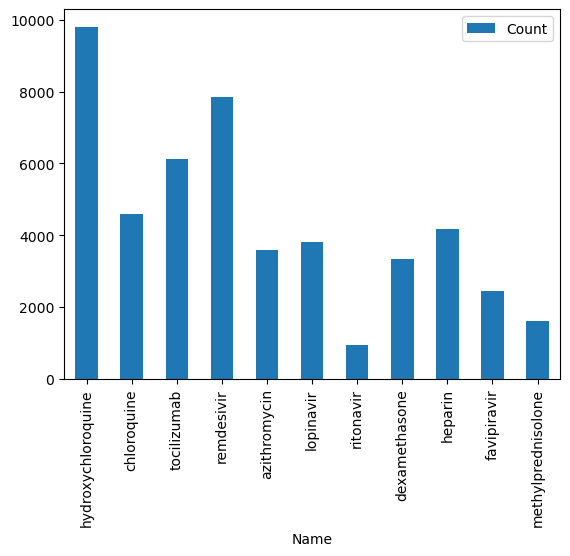

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## البحث عن اتجاهات في استراتيجية العلاج

في المثال أعلاه، قمنا بـ `sum` لجميع القيم، ولكن يمكننا أيضًا القيام بنفس الشيء على أساس شهري:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

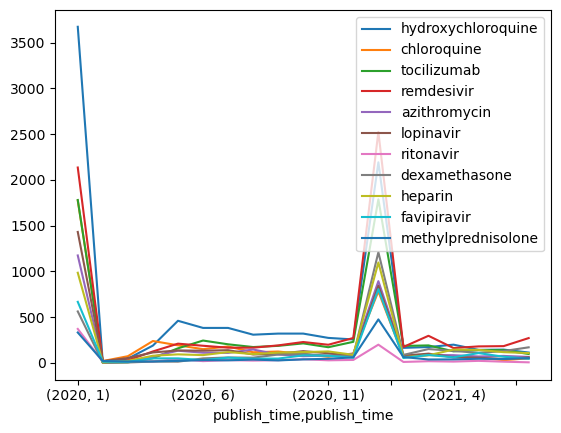

In [152]:
dfmt.plot()
plt.show()

ملاحظة مثيرة للاهتمام هي أننا نلاحظ ارتفاعات كبيرة في موقعين: يناير 2020 ويناير 2021. السبب وراء ذلك هو أن بعض الأوراق البحثية لا تحتوي على تاريخ نشر محدد بوضوح، ويتم تحديدها كيناير للسنة المعنية.

لجعل البيانات أكثر وضوحًا، دعونا نعرض فقط بعض الأدوية. سنقوم أيضًا "بمحو" البيانات الخاصة بشهر يناير، وملؤها بقيمة متوسطة، لجعل الرسم البياني أكثر جمالًا:


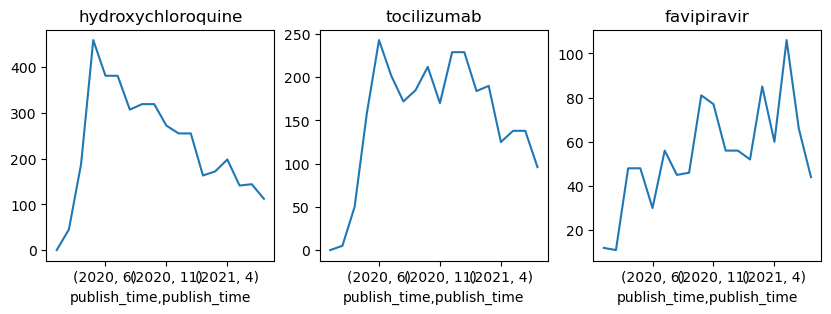

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

لاحظ كيف كانت شعبية الهيدروكسي كلوروكين في ارتفاع خلال الأشهر الأولى، ثم بدأت في الانخفاض، بينما يظهر عدد الإشارات إلى الفافيبيرافير ارتفاعًا مستقرًا. طريقة جيدة أخرى لتصور الشعبية النسبية هي استخدام **مخطط مكدس** (أو **مخطط المنطقة** في مصطلحات Pandas):


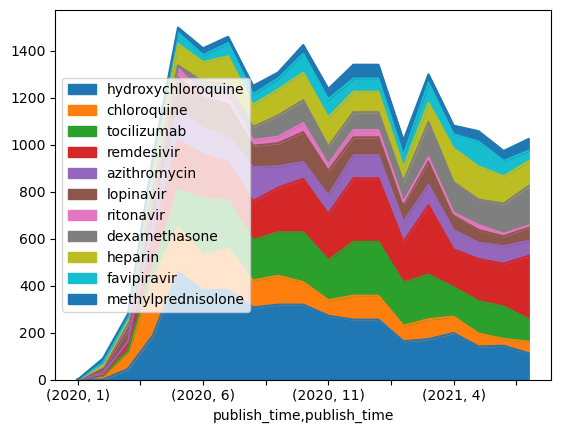

In [154]:
dfmt.plot.area()
plt.show()

حتى أكثر من ذلك، يمكننا حساب الشعبية النسبية بالنسب المئوية:


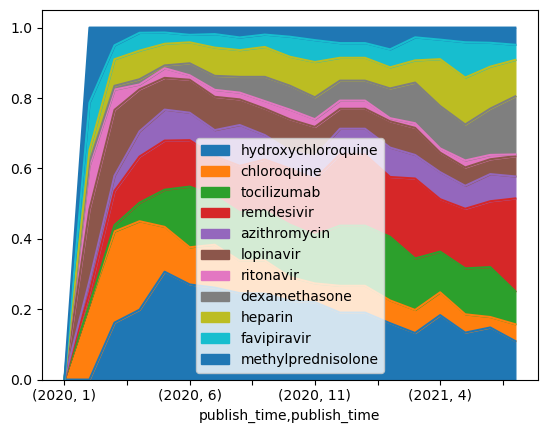

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## حساب التوافق بين التشخيصات والأدوية

إحدى العلاقات الأكثر إثارة للاهتمام التي يمكننا البحث عنها هي كيفية علاج التشخيصات المختلفة بأدوية مختلفة. ولتصور ذلك، نحتاج إلى حساب **خريطة تكرار التزامن**، التي ستظهر عدد المرات التي يتم فيها ذكر مصطلحين في نفس الورقة.

هذه الخريطة هي في الأساس مصفوفة ثنائية الأبعاد، والتي يتم تمثيلها بشكل أفضل باستخدام **numpy array**. سنقوم بحساب هذه الخريطة من خلال استعراض جميع الملخصات وتحديد الكيانات التي تظهر فيها:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

إحدى الطرق لتصور هذه المصفوفة هي رسم **خريطة حرارية**:


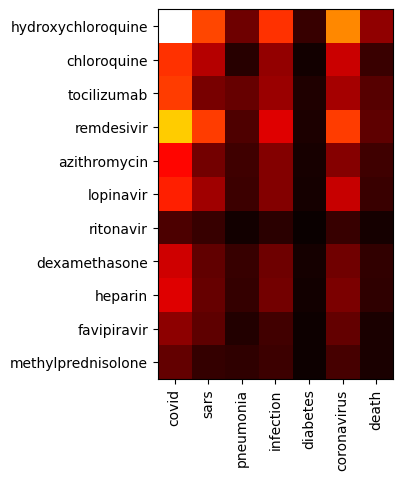

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

ومع ذلك، يمكن تحقيق تصور أفضل باستخدام ما يسمى **مخطط سانكي**! مكتبة `matplotlib` لا تحتوي على دعم مدمج لهذا النوع من المخططات، لذا سيتعين علينا استخدام [Plotly](https://plotly.com/python/) كما هو موضح [في هذا الدليل](https://plotly.com/python/sankey-diagram/).

لإنشاء مخطط سانكي باستخدام Plotly، نحتاج إلى بناء القوائم التالية:
* قائمة `all_nodes` التي تحتوي على جميع العقد في الرسم البياني، والتي ستشمل الأدوية والتشخيصات.
* قائمة المؤشرات المصدر والهدف - هذه القوائم ستوضح أي العقد تتجه إلى الجزء الأيسر وأيها إلى الجزء الأيمن من المخطط.
* قائمة جميع الروابط، وكل رابط يتكون من:
   - مؤشر المصدر في مصفوفة `all_nodes`.
   - مؤشر الهدف.
   - قيمة تشير إلى قوة الرابط. هذه القيمة هي بالضبط القيمة من مصفوفة التكرار المشترك لدينا.
   - اختيارياً لون الرابط. سنوفر خياراً لتسليط الضوء على بعض المصطلحات لتوضيحها.

الكود العام لرسم مخطط سانكي يتم تنظيمه كدالة منفصلة باسم `sankey`، والتي تأخذ قائمتين (فئات المصدر والهدف) ومصفوفة التكرار المشترك. كما تتيح لنا تحديد العتبة، وتجاهل جميع الروابط التي تكون أضعف من تلك العتبة - مما يجعل المخطط أقل تعقيداً قليلاً.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## الخاتمة

لقد رأيت أنه يمكننا استخدام طرق بسيطة للغاية لاستخراج المعلومات من مصادر البيانات غير المهيكلة، مثل النصوص. في هذا المثال، قمنا باستخدام قائمة الأدوية الموجودة، ولكن سيكون أكثر قوة استخدام تقنيات معالجة اللغة الطبيعية (NLP) لاستخراج الكيانات من النصوص. في [هذه المقالة](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) نصف كيفية استخدام خدمات السحابة لاستخراج الكيانات. خيار آخر سيكون استخدام مكتبات Python لمعالجة اللغة الطبيعية مثل [NLTK](https://www.nltk.org/) - تم وصف نهج لاستخراج المعلومات من النصوص باستخدام NLTK [هنا](https://www.nltk.org/book/ch07.html).


## التحدي

تابع البحث في بيانات الأوراق المتعلقة بـ COVID وفقًا للمحاور التالية:

1. قم ببناء مصفوفة التشارك (co-occurrence matrix) للأدوية المختلفة، وتحقق من الأدوية التي غالبًا ما يتم ذكرها معًا (أي مذكورة في ملخص واحد). يمكنك تعديل الكود لبناء مصفوفة التشارك للأدوية والتشخيصات.
1. قم بتصور هذه المصفوفة باستخدام خريطة حرارية (heatmap).
1. كهدف إضافي، قد ترغب في تصور التشارك بين الأدوية باستخدام [مخطط الوتر](https://en.wikipedia.org/wiki/Chord_diagram). [هذه المكتبة](https://pypi.org/project/chord/) قد تساعدك في رسم مخطط الوتر.
1. كهدف إضافي آخر، حاول استخراج الجرعات المختلفة للأدوية (مثل **400mg** في *تناول 400mg من الكلوروكين يوميًا*) باستخدام التعبيرات النمطية (regular expressions)، وقم ببناء إطار بيانات (dataframe) يعرض الجرعات المختلفة للأدوية المختلفة. **ملاحظة**: ضع في اعتبارك القيم الرقمية التي تكون قريبة نصيًا من اسم الدواء.



---

**إخلاء المسؤولية**:  
تم ترجمة هذا المستند باستخدام خدمة الترجمة بالذكاء الاصطناعي [Co-op Translator](https://github.com/Azure/co-op-translator). بينما نسعى لتحقيق الدقة، يرجى العلم أن الترجمات الآلية قد تحتوي على أخطاء أو معلومات غير دقيقة. يجب اعتبار المستند الأصلي بلغته الأصلية المصدر الموثوق. للحصول على معلومات حاسمة، يُوصى بالاستعانة بترجمة بشرية احترافية. نحن غير مسؤولين عن أي سوء فهم أو تفسيرات خاطئة تنشأ عن استخدام هذه الترجمة.
